# Overall Data Analysis

This notebook aims to demonstrate some possibilities of data exploratory analysis to reveal insights about the problem.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
warnings.filterwarnings('ignore')

# definition of constants
DATASOURCE = '../../data/2_processed'
DATANAME = 'train.csv'

In [2]:
# load the data
data = pd.read_csv(os.path.join(DATASOURCE, DATANAME))
data.head()

,history_id,runtime,set1,set2,tag2,tag3,tag4,tag7,tag9,tag11,tag12,tag14,tag15,tag17,tag20,tag21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,9046.19,47.47,521.66,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,9044.07,47.49,522.28,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,9052.94,47.27,522.42,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,9049.48,47.13,522.86,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,9055.15,47.28,522.19,8133.80,8.4294,393,38.90,23.4044


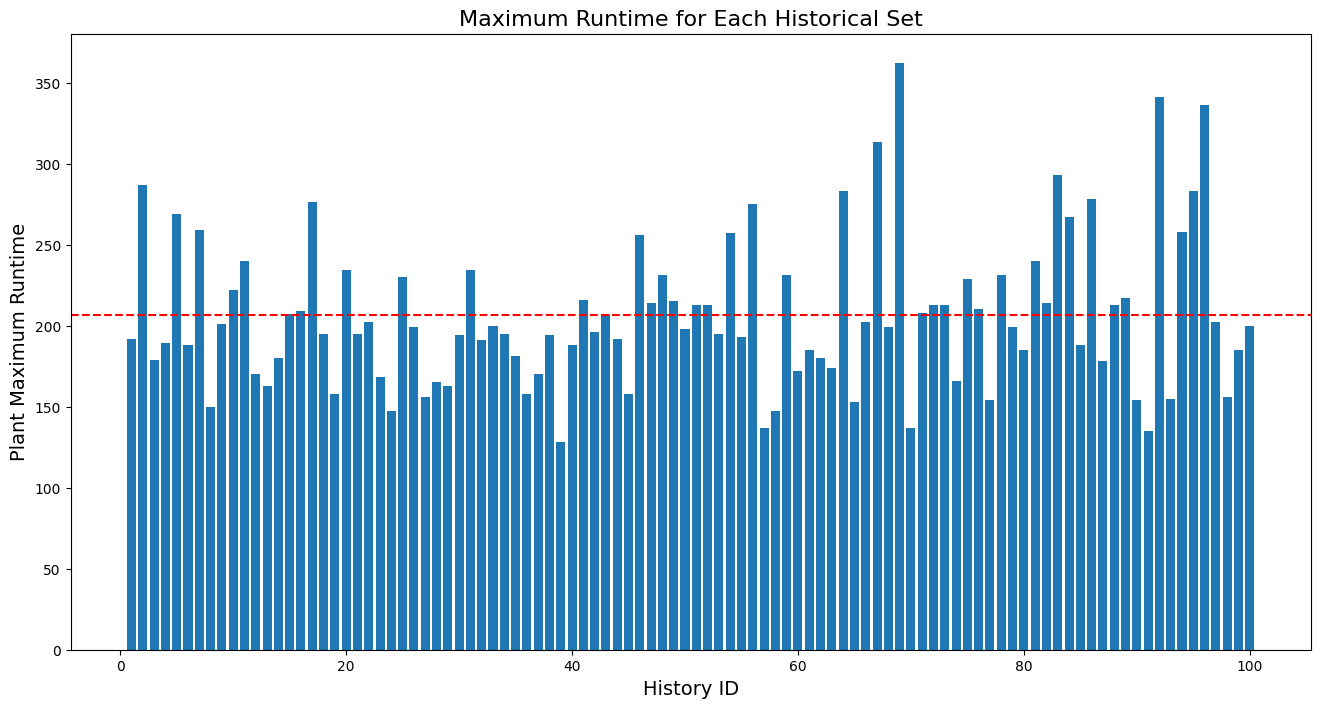

In [3]:
# are there occasions that the plant lasted longer than others?
max_runtime = pd.DataFrame(
    data.groupby(['history_id'])['runtime'].max().values,
    columns=['max_runtime'],
    index=data.groupby(['history_id'])['runtime'].max().index
)
plt.figure(figsize=(16, 8))
plt.bar(max_runtime.index, max_runtime.max_runtime.values)
plt.axhline(max_runtime.max_runtime.mean(), ls='--', color='red')
plt.xlabel('History ID', size=14)
plt.ylabel('Plant Maximum Runtime', size=14)
plt.title('Maximum Runtime for Each Historical Set', size=16)
plt.show()

In [4]:
# check max runtime set
max_runtime

,max_runtime
history_id,
1,192
2,287
3,179
4,189
5,269
...,...
96,336
97,202
98,156


In [5]:
# lets split the data into two categoris (0: lasted below average, 1: lasted above average)
abov_idx = max_runtime.loc[max_runtime.max_runtime > max_runtime.max_runtime.mean()].index
below_idx = max_runtime.loc[max_runtime.max_runtime < max_runtime.max_runtime.mean()].index

# put category
data.loc[abov_idx, 'categ'] = 1
data.loc[below_idx, 'categ'] = 0

In [6]:
# check data distribution
data.categ.value_counts(normalize=True)

0.0    0.58
1.0    0.42
Name: categ, dtype: float64

In [7]:
# compare the average values of the process variables
to_compare = [c for c in data.columns if c not in ['history_id', 'runtime']]

data[to_compare].groupby(['categ']).mean().T

categ,0.0,1.0
set1,-0.000066,-0.000074
set2,0.000010,0.000079
tag2,642.319655,642.364762
tag3,1587.235345,1585.804048
tag4,1401.272931,1402.360714
tag7,554.021552,553.999048
tag9,9049.808793,9050.092619
tag11,47.339655,47.324524
tag12,522.028621,521.884286
tag14,8131.454655,8132.735476


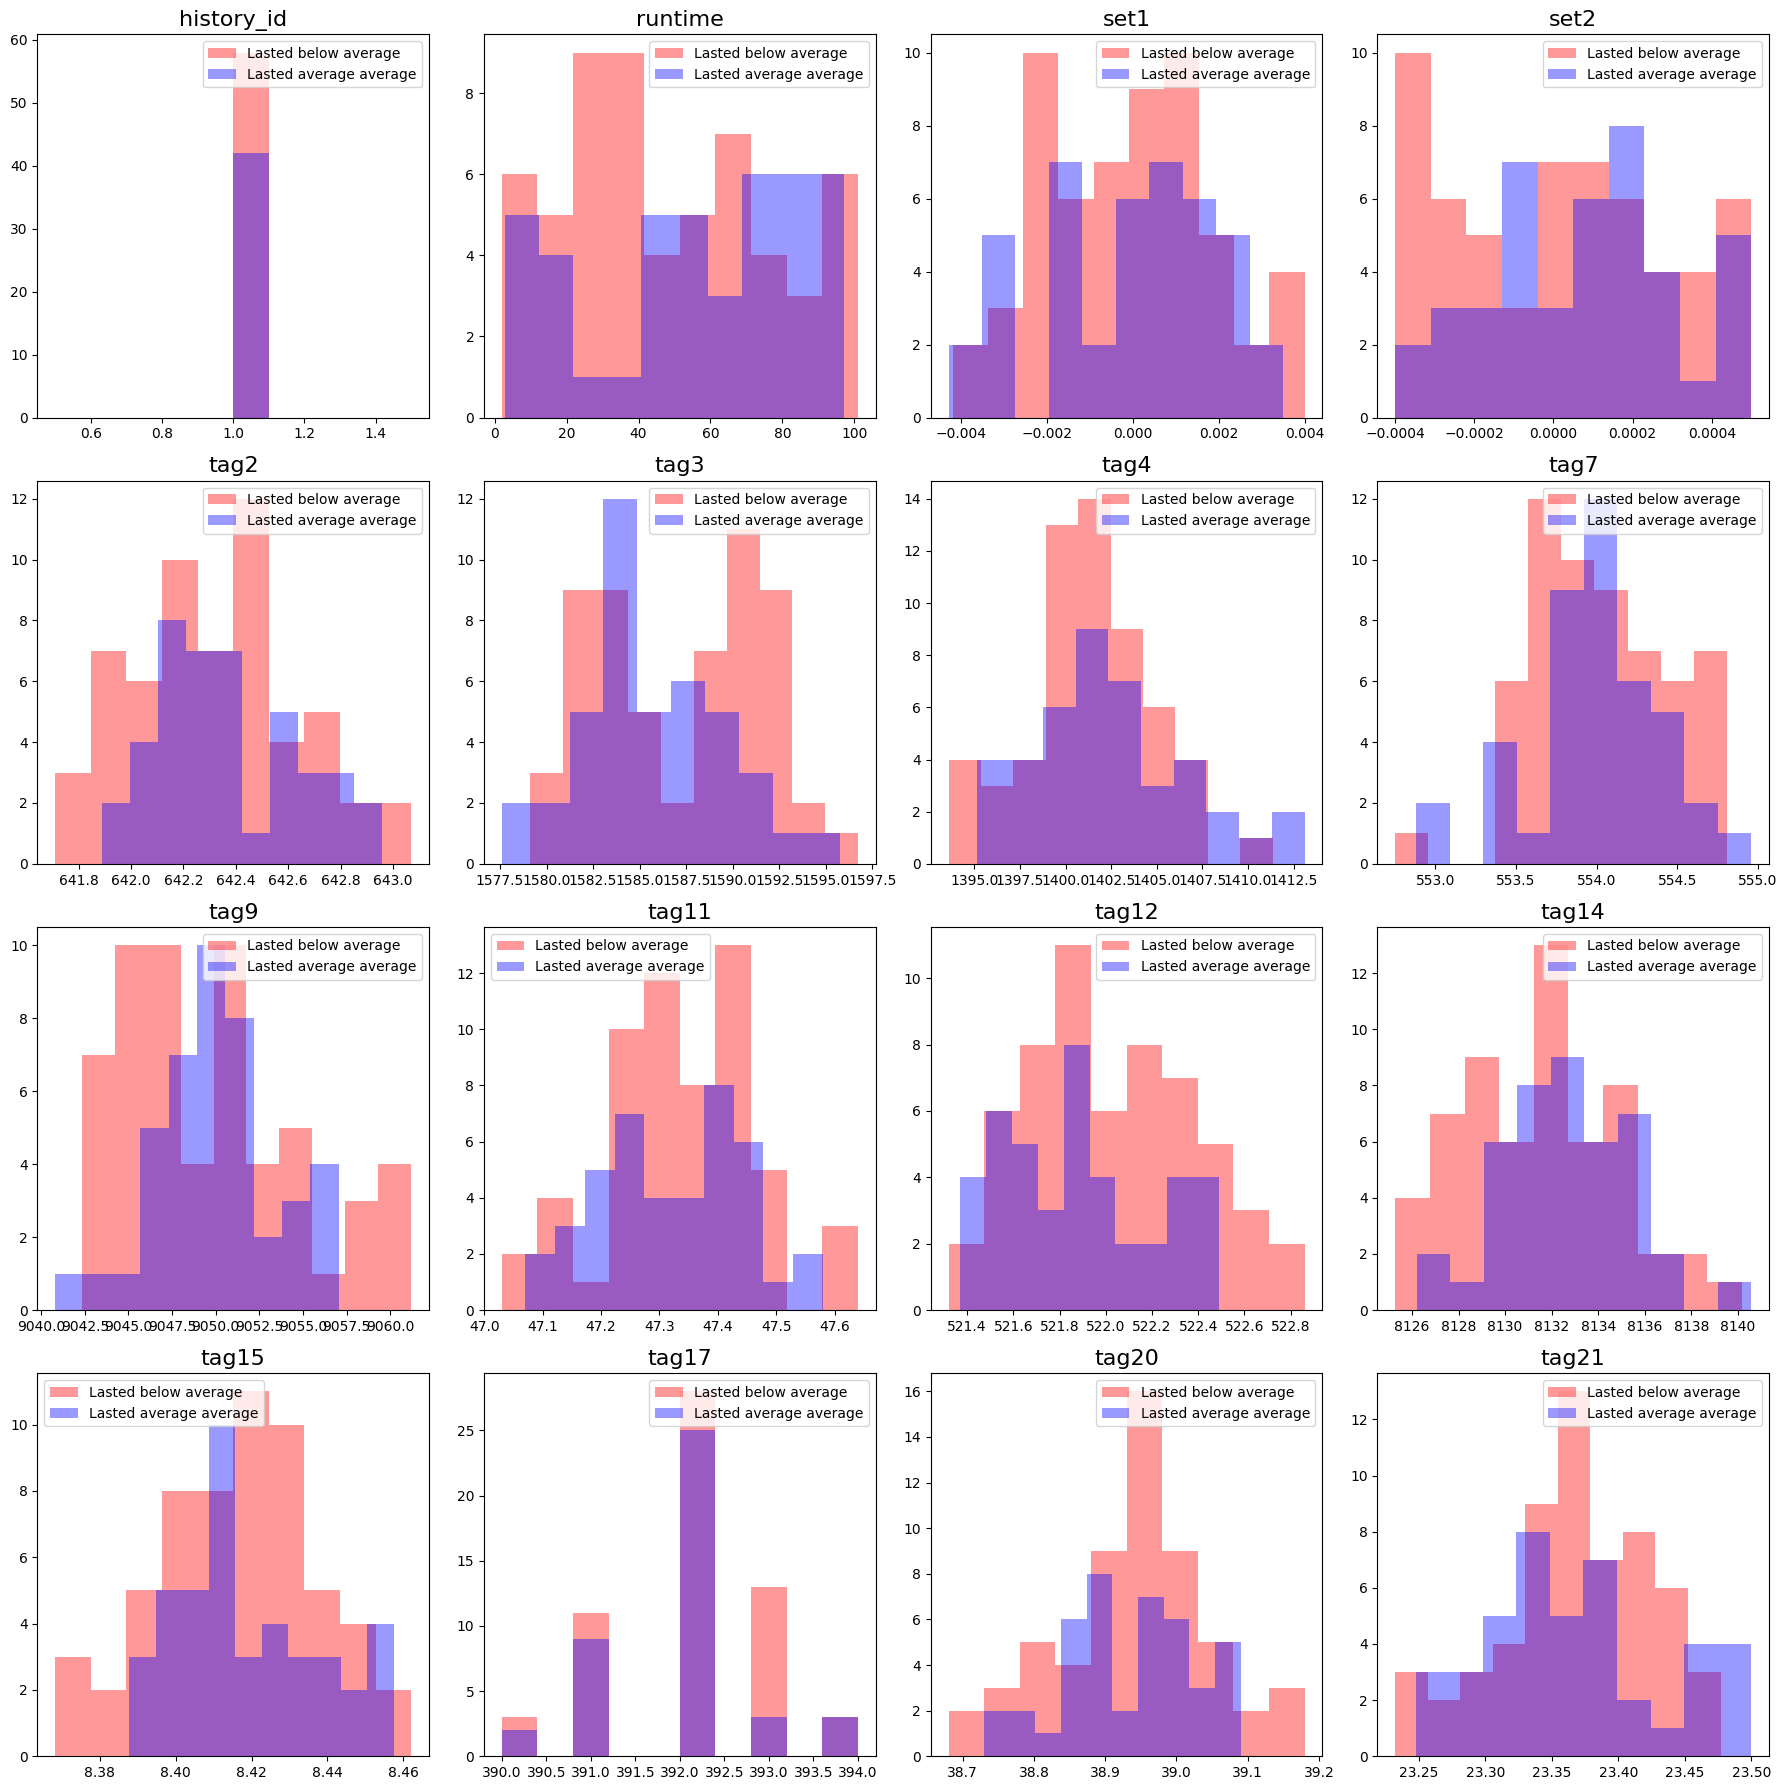

In [8]:
# check the distribution comparisons
fig = plt.figure(figsize=(18, 18))
for i in range(1, 17):
    ax = fig.add_subplot(4, 4, i)
    ax.hist(data.loc[data.categ==0,:].iloc[:, i-1], color='red', alpha=0.4, label='Lasted below average')
    ax.hist(data.loc[data.categ==1,:].iloc[:, i-1], color='blue', alpha=0.4, label='Lasted average average')
    ax.set_title(data.columns[i-1], size=16)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
# lets go deeper into our classification problem and make the feature transformation to look for the failure into the next
# 20 cycles
def create_failure_class(row: pd.DataFrame, data: pd.DataFrame) -> int:
    """
    create a failure class
    1 - the plant will fail in the next 20 cycles
    0 - the plant will not fail in the next 20 cycles

    Parameters
    ----------
    row : pd.DataFrame
        dataframe row
    data : pd.DataFrame
        grouped dataset with the maximum runtime

    Returns
    -------
    int
        failure class
    """
    # business threshold
    FORECAST_WINDOW = 20

    # get the maxium runtime of that specific history id
    max_runtime_id = data.loc[row['history_id'], 'max_runtime']

    if row['runtime'] + FORECAST_WINDOW > max_runtime_id:
        return 1
    else:
        return 0

In [10]:
data['categ'] = data.apply(create_failure_class, data=max_runtime, axis=1)

# check class balances
data['categ'].value_counts(normalize=True)

0    0.903059
1    0.096941
Name: categ, dtype: float64

In [11]:
# check again differences in the averages
data[to_compare].groupby(['categ']).mean().T

categ,0,1
set1,-0.000017,0.000063
set2,0.000002,0.000007
tag2,642.594677,643.484460
tag3,1589.500836,1600.046190
tag4,1407.214776,1424.947175
tag7,553.531659,551.840455
tag9,9062.453409,9091.228820
tag11,47.488629,48.030600
tag12,521.552917,520.114455
tag14,8141.791035,8162.026820


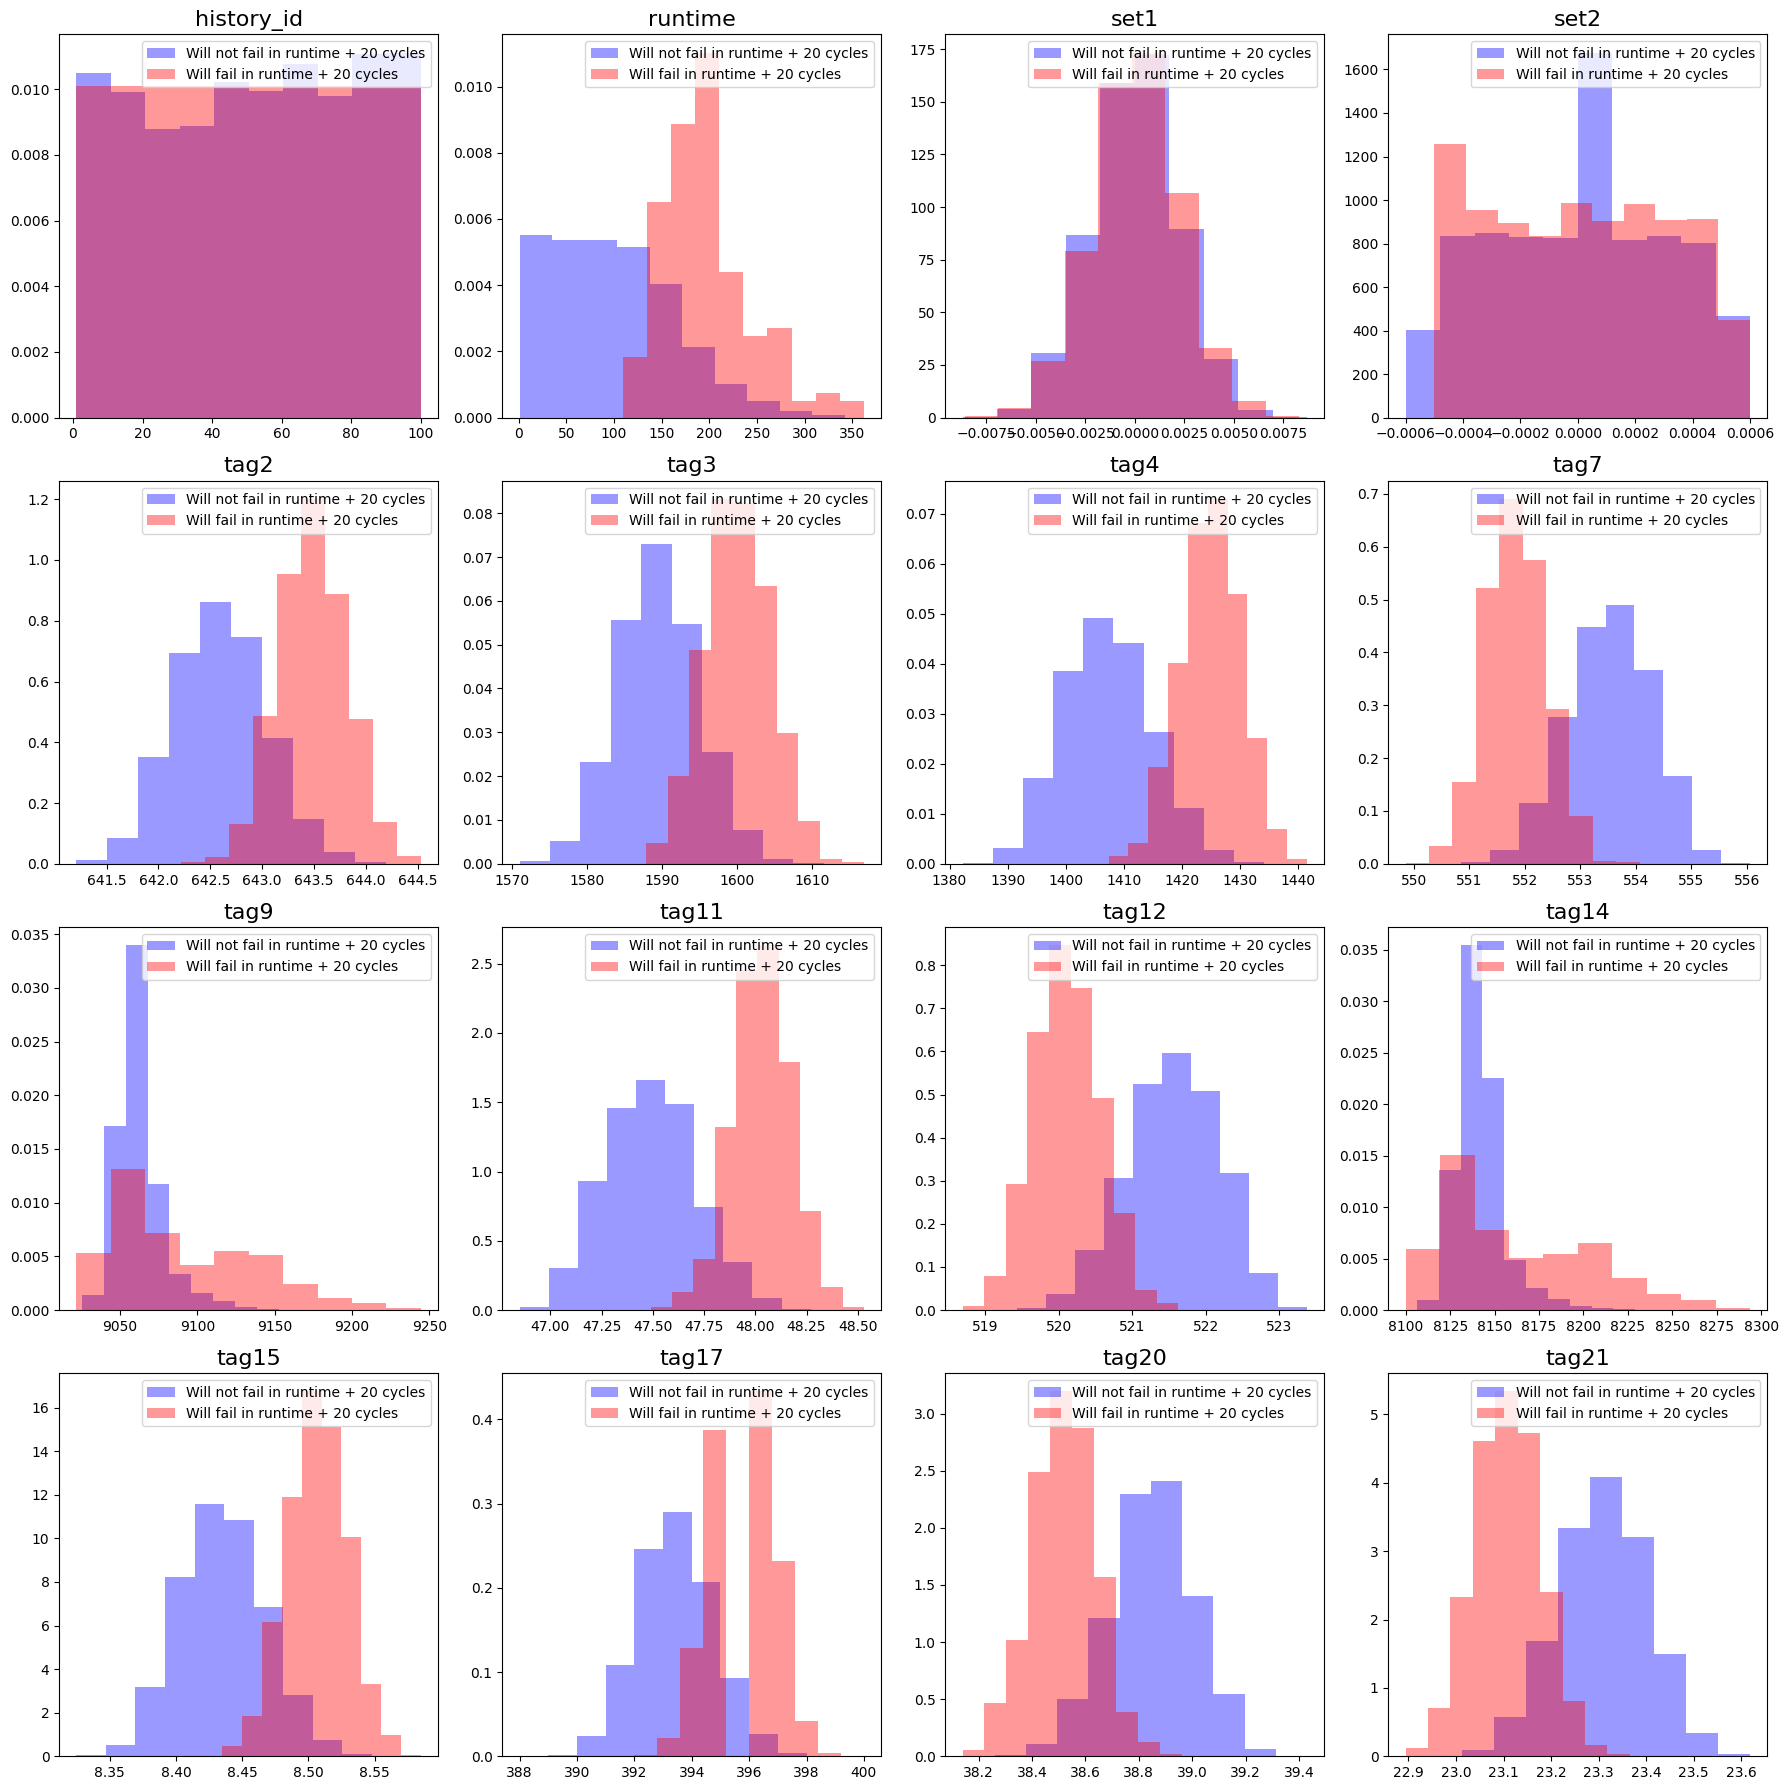

In [12]:
# check the distribution comparisons
fig = plt.figure(figsize=(18, 18))
for i in range(1, 17):
    ax = fig.add_subplot(4, 4, i)
    ax.hist(data.loc[data.categ==0,:].iloc[:, i-1], color='blue', alpha=0.4, label='Will not fail in runtime + 20 cycles', density=True)
    ax.hist(data.loc[data.categ==1,:].iloc[:, i-1], color='red', alpha=0.4, label='Will fail in runtime + 20 cycles', density=True)
    ax.set_title(data.columns[i-1], size=16)
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [13]:
# lets analyse the correlations with the RUL (remaining useful life)

# calculate the rul
data['rul'] = 0
for id in max_runtime.index:

    # extract the maximum runtime by index
    max_runtime_id = max_runtime.loc[id, 'max_runtime']

    # calculate the rlu
    data.loc[data.history_id==id, 'rul'] = max_runtime_id - data.loc[data.history_id==id, 'runtime']

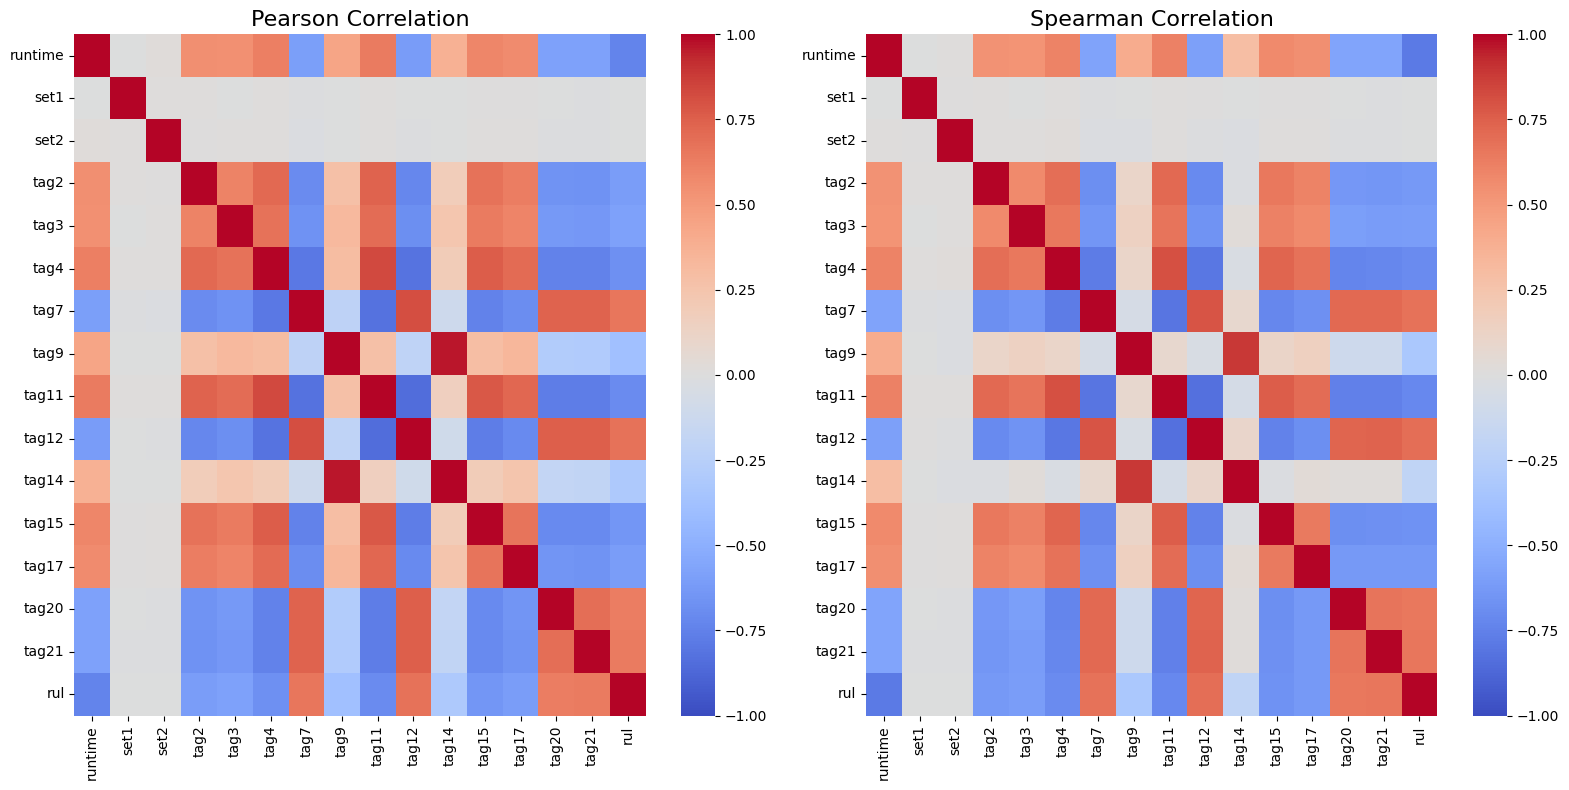

In [14]:
# check the correlation of the process variables with the rlu
to_check = [c for c in data.columns if c not in ['history_id', 'categ']]

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, 1)
sns.heatmap(data[to_check].corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=ax)
ax.set_title('Pearson Correlation', size=16)

ax = fig.add_subplot(1, 2, 2)
sns.heatmap(data[to_check].corr(method='spearman'), vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=ax)
ax.set_title('Spearman Correlation', size=16)

plt.tight_layout()
plt.show()

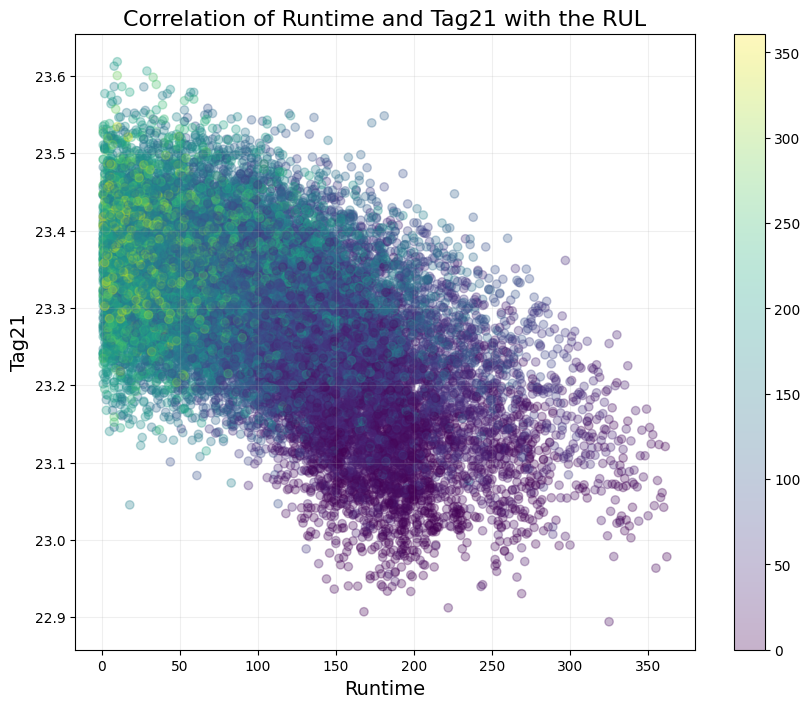

In [18]:
# check the format of the correlation
plt.figure(figsize=(10, 8))
plt.scatter(data.runtime, data.tag21, c=data.rul, alpha=0.3)
plt.xlabel('Runtime', size=14)
plt.ylabel('Tag21', size=14)
plt.title('Correlation of Runtime and Tag21 with the RUL', size = 16)
plt.colorbar()
plt.grid(True, alpha=0.2)
plt.show()

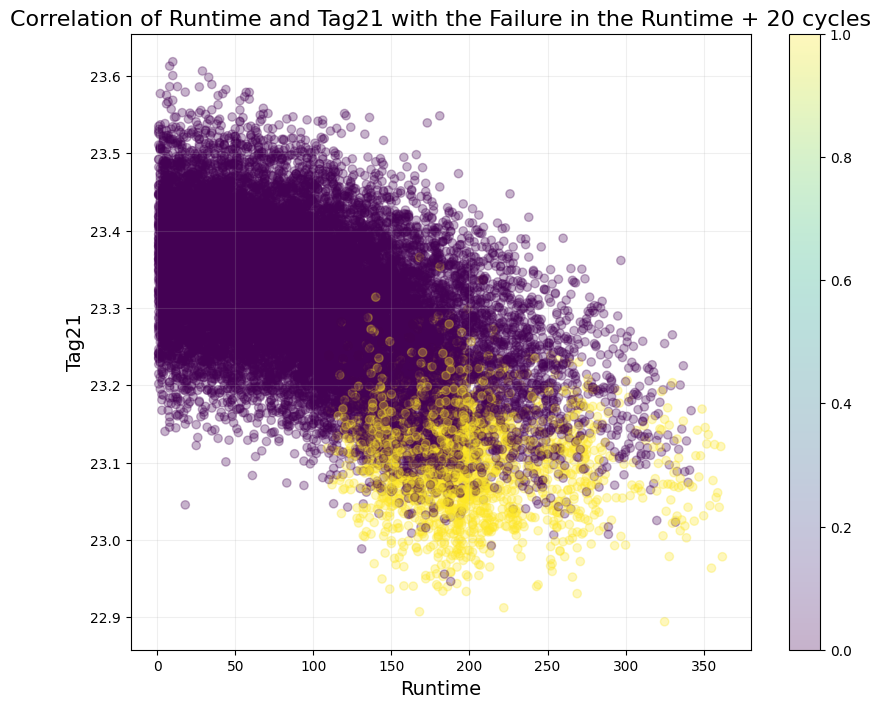

In [20]:
# check the format of the correlation
plt.figure(figsize=(10, 8))
plt.scatter(data.runtime, data.tag21, c=data.categ, alpha=0.3)
plt.xlabel('Runtime', size=14)
plt.ylabel('Tag21', size=14)
plt.title('Correlation of Runtime and Tag21 with the Failure in the Runtime + 20 cycles', size = 16)
plt.colorbar()
plt.grid(True, alpha=0.2)
plt.show()